# Analyze the growth of the colony in z and in radial direction

In [1]:
#Dependencies
%matplotlib notebook

import numpy as np
import pandas as pd
import cv2
import sys

import colony_iomethods as cm
import xml.etree.ElementTree as ET # for XML properties
import tracker as tm

from matplotlib import pyplot as plt

## File paths

In [2]:
# Filename
fname = "3dTimeScan_17h_init_long"
tstrar = ["t%02d" % (tix) for tix in range(48)]    # all of the timepoint information

# Working folder
folder = "C:/Users/Tolga/Dropbox/Raw Data/Colony Images - Confocal/02112020/" + fname + "/"

#Video folder and path
vidfolder = "Videos/"

# XML properties file
xml_name = "Metadata/EQ59_Single_Colony_TilesScan.lif_" + fname + "_Properties.xml"
xml_path = folder + xml_name

### Important!! 
#### Each frame is scaled from a tilescan of 1024x1024 images, to a final 512x512 in the video.
* Collect the tilescan positions and obtain the scalex and scaley

* Scale xvoxel and yvoxel accordingly

### Read XML properties

In [3]:
tree = ET.parse(xml_path)    # xml tree of the current stage position
root = tree.getroot()           # root of the xml tree

image_xml = root[0]

# Tilescan properties
tilescan_desc = cm.collectTileScan(image_xml)
# Number of tiles in x- and y- directions
tile_xcnt = tilescan_desc["tile_xcnt"]
tile_ycnt = tilescan_desc["tile_ycnt"]
# Scale factors
scalex = 1.0/tile_xcnt/2
scaley = 1.0/tile_ycnt/2

dim_desc = cm.collectImageDim(image_xml)
xsz = dim_desc["xsz"]
ysz = dim_desc["ysz"]
zsz = dim_desc["zsz"]
tsz = dim_desc["tsz"]
xvoxel = dim_desc["xvoxel"]/scalex
yvoxel = dim_desc["yvoxel"]/scaley
zvoxel = dim_desc["zvoxel"]
xunit = dim_desc["xunit"]
yunit = dim_desc["yunit"]
zunit = dim_desc["zunit"]

# ROI in um
xsmall = 443
xlarge = 3200
ysmall = 450
ylarge = 3220

# Accepted ROI is in range xsmall, xlarge, ysmall, ylarge
# Calculate the corresponding indices: xixsmall, xixlarge, yixsmall, yixlarge
# xvoxel*xixsmall = xsmall
xixsmall = np.uint16(xsmall/xvoxel)
xixlarge = np.uint16(xlarge/xvoxel)
yixsmall = np.uint16(ysmall/yvoxel)
yixlarge = np.uint16(ylarge/yvoxel)
roi_ix = [xixsmall, xixlarge, yixsmall, yixlarge]

tilescan is set


## Read video frames and save to a numpy 4d array (y,x,z,t)
### !! Near-future: 
Find all the videopaths, and extract time information from the filenames
### !! Distant-future:
Collect the timestamp information for each tilescan, and read the growth rate from the portion (will be more exact)

In [5]:
# Extract height, width and frame count from a sample video capture object
sample_video_path = folder + vidfolder + fname + "_" + tstrar[0] + ".avi"
sample_vid = cv2.VideoCapture(sample_video_path)

# # Frame properties as captured from the sample video
# frame_height = int(sample_vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
# frame_width = int(sample_vid.get(cv2.CAP_PROP_FRAME_WIDTH))
# Frame properties as captured from the ROI
frame_height = yixlarge-yixsmall
frame_width = xixlarge-xixsmall
frame_count = int(sample_vid.get(cv2.CAP_PROP_FRAME_COUNT))
# Numpy 4darray to keep all the frames
img_seq = np.zeros((frame_height, frame_width, frame_count, len(tstrar)), dtype=np.uint8)

for tix in range(len(tstrar)):
    print("\rSaving time %d, frame_count = %d" % (tix, frame_count), end="")
    sys.stdout.flush()
    tstr = tstrar[tix]
    vidpath = sample_video_path = folder + vidfolder + fname + "_" + tstr + ".avi"
    vidcap = cv2.VideoCapture(vidpath)
    for frix in range(frame_count):
        zval = frix*zvoxel
        success,frame = vidcap.read()
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        img_seq[:, :, frix, tix] = frame_gray[yixsmall:yixlarge, xixsmall:xixlarge]
    

Saving time 47, frame_count = 235

## Radial growth

### Interactive plot of the total intensity z stacks
### Near-future: interactive scroll through each timepoint

In [6]:
# Total intensity information for each z and t
total_intensity = img_seq.sum(axis=0).sum(axis=0)

<IPython.core.display.Javascript object>


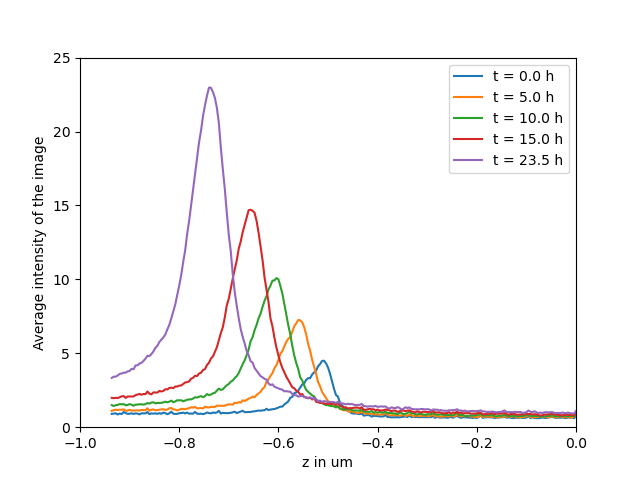

In [244]:
zar = np.arange(0,zvoxel*zsz, zvoxel) # z values
max_zixar = np.zeros(len(tstrar), dtype=np.uint32) # indices of the max intensity of z
tvoxel = 0.5 # 30minute time intervals
dzdt = -0.008
plot_cnt = 0 # counter for plotting
tixplot_ar = [0,10,20,30,47] # Plot for these tix values [near-future implementation for all tix values]
fig_zsum, ax = plt.subplots(1,1, num=1)
for tix in range(len(tstrar)):
    zsum_at_tix = total_intensity[:,tix] # total intensity at fixed tix
    max_zixar[tix] = np.argmax(zsum_at_tix)
    zsum_at_tix_norm = zsum_at_tix/zsum_at_tix[max_zixar[tix]]
    
    
    # Plotting at chosen indices
    if tix == tixplot_ar[plot_cnt]:
        ax.plot(zar,zsum_at_tix/frame_height/frame_width, label="t = %.1f h" % (tix*tvoxel))
#         ax.plot(zar-dzdt*tar[tix],zsum_at_tix_norm, label="t = %.1f h" % (tix*tvoxel))
        plot_cnt += 1

# Plot properties
ax.set_xlabel("z in um")
ax.set_ylabel("Average intensity of the image")
ax.set_xlim(-1,0)
ax.set_ylim(0,25)
ax.legend()



# Interactive plot for visualizing radial growth

<IPython.core.display.Javascript object>


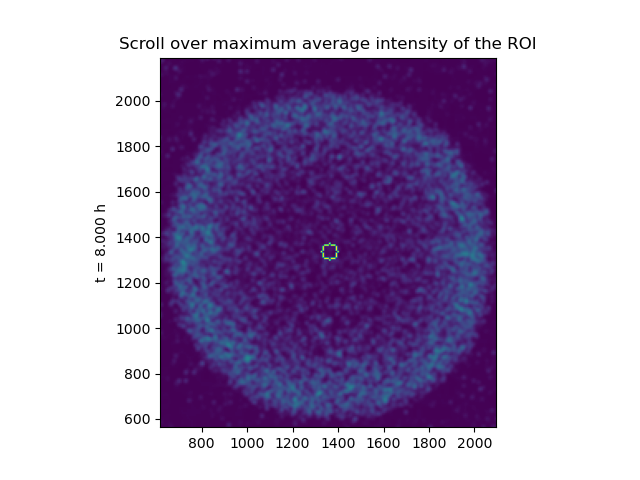

In [157]:
extent = [0, frame_width*xvoxel, 0, frame_height*yvoxel] # Extent written for x-y scales

tar = np.array([int(tstrar[d][1:])*tvoxel for d in range(len(tstrar))])
# Dictionary to pass into Index Tracker
args_dict = {"extent": extent, "zvals": tar, "zunit": "h", "zstr": "t",
            "title": "Scroll over maximum average intensity of the ROI",
            }

img_seq_maxz = np.zeros((frame_height, frame_width, len(tstrar))) # numpy 3d array image sequence to track max intensity images
for tix in range(len(tstrar)):
    roi_image = img_seq[:, :, max_zixar[tix], tix]
    blurred_image = cv2.GaussianBlur(roi_image, (5,5), 0)
    equalized_image = cv2.equalizeHist(blurred_image)
    ret, threshold_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
#     # Use threshold_image for manually measuring the radius and the center
#     img_seq_maxz[:, :, tix] = threshold_image
    # Use blurred_image for nice plots
    cv2.circle(blurred_image, (187, 197), 5, (255,255,255), 1)
    img_seq_maxz[:, :, tix] = blurred_image
        

# Plot the image sequence in a figure
fig_maxint_img, ax = plt.subplots(1, 1, num=2)
tracker = tm.IndexTracker(ax, img_seq_maxz, args_dict)
fig_maxint_img.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

### Radial Growth rate (measure by hand)
* Gaussian blur image with (11,11) kernel size
* Use OTSU thresholding

<IPython.core.display.Javascript object>


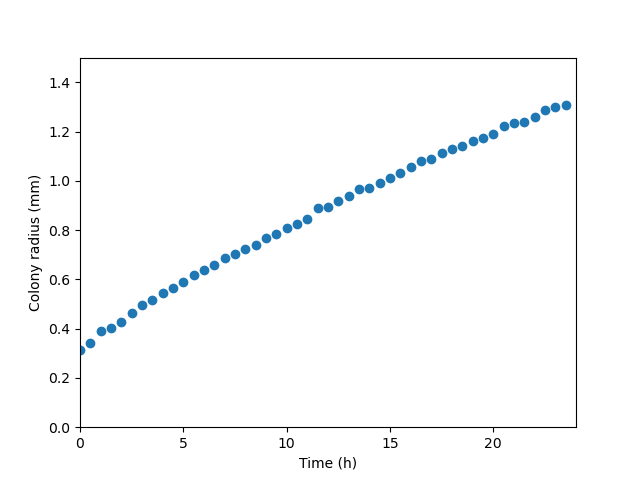

array([ 41.64937039, 373.95323129])

In [252]:
left = np.array([1036, 1010, 962, 949, 925, 888, 856, 833, 805, 788, 761, 734, 714, 691, 664, 648, 629, 611, 584, 565, 541, 526, 506, 463, 459, 432, 413, 385, 381, 359, 340, 320, 296, 271, 262, 237, 223, 208, 189, 179, 160, 130, 116, 111, 91, 62, 52, 43])
center = (1351, 1321)

rad_left = -(left-center[0])

fig_rad, ax_rad = plt.subplots(1,1, num=3)
ax_rad.plot(tar, rad_left/1e3, 'o')
ax_rad.set_xlabel("Time (h)")
ax_rad.set_ylabel("Colony radius (mm)")
ax_rad.set_xlim(0,24)
ax_rad.set_ylim(0,1.5)

np.polyfit(tar, rad_left, 1)



## Height growth from avg intensity around the center

### Near future: take an average in a circle around the center with a defined radius

In [164]:
def window(size):
    return np.ones(size)/float(size)

In [228]:
# centerx = 1351
# centery = 1321
# centerxix = np.uint16(centerx/xvoxel)
# centeryix = np.uint16(centery/yvoxel)

centerxix = 187
centeryix = 197

# square with 11x11 pixel average intensity at the center
sqsz = 21
sqsmall = int((sqsz-1)/2)
sqlarge = int(sqsmall+1)
# First get intensity average at 
center_avg = np.zeros_like(zar)
# Calculate the top and bottom of the colony for each timepoint
colony_top_zval = np.zeros_like(tar)
colony_bottom_zval = np.zeros_like(tar)
for tix in range(len(tar)):
    for zix in range(len(zar)):
        center_square = img_seq[(centeryix-sqsmall):(centeryix+sqlarge),(centerxix-sqsmall):(centerxix+sqlarge),zix,tix]
        center_avg[zix] = center_square.mean()
    center_avg_tavg = np.convolve(center_avg, window(11), 'same')
    colony_top_zval[tix] = zar[np.argmax(center_avg_tavg)]
    colony_bottom_zval[tix] = (zar[(center_avg_tavg/center_avg_tavg.max())>0.5])[-1]
    

<IPython.core.display.Javascript object>


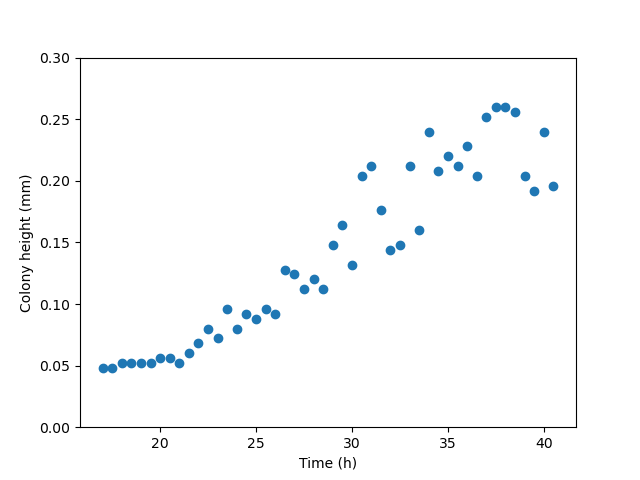

array([0.00976203, 0.02553699])

In [250]:
fig,ax = plt.subplots(1,1,num=4)
ax.plot(tar+17, colony_top_zval - colony_bottom_zval, 'o')
# ax.set_xlim(10)
ax.set_ylim(0,0.3)
ax.set_xlabel("Time (h)")
ax.set_ylabel("Colony height (mm)")

np.polyfit(tar[15:], colony_top_zval[15:] - colony_bottom_zval[15:], 1)

In [238]:
rad_left/1e3

array([0.315, 0.341, 0.389, 0.402, 0.426, 0.463, 0.495, 0.518, 0.546,
       0.563, 0.59 , 0.617, 0.637, 0.66 , 0.687, 0.703, 0.722, 0.74 ,
       0.767, 0.786, 0.81 , 0.825, 0.845, 0.888, 0.892, 0.919, 0.938,
       0.966, 0.97 , 0.992, 1.011, 1.031, 1.055, 1.08 , 1.089, 1.114,
       1.128, 1.143, 1.162, 1.172, 1.191, 1.221, 1.235, 1.24 , 1.26 ,
       1.289, 1.299, 1.308])

In [137]:
centeryix

181